In [1]:
import datetime as dt
from pathlib import Path
import seaborn as sns
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
%matplotlib inline

In [2]:
load_dotenv()

True

In [3]:
###Set Alpaca API key and secret
alpaca_api_key = os.getenv("api_key_id")
alpaca_secret_key = os.getenv("secret_api_key")
###Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [4]:
# Open S&P 500 historical prices
file_path = Path("Resources\S&P500_5years.csv")
sp500 = pd.read_csv(file_path, parse_dates=True, index_col="Date", infer_datetime_format=True)
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-11-04,2110.600098,2114.590088,2096.979980,2102.310059,2102.310059,4078870000
2015-11-05,2101.679932,2108.780029,2090.409912,2099.929932,2099.929932,4051890000
2015-11-06,2098.600098,2101.909912,2083.739990,2099.199951,2099.199951,4369020000
2015-11-09,2096.560059,2096.560059,2068.239990,2078.580078,2078.580078,3882350000
2015-11-10,2077.189941,2083.669922,2069.909912,2081.719971,2081.719971,3821440000


In [5]:
# Fetch the closing prices of S&P500
sp500_closing_prices = pd.DataFrame()
sp500_closing_prices["S&P500"] = sp500["Close"]
sp500_closing_prices

,S&P500
Date,
2015-11-04,2102.310059
2015-11-05,2099.929932
2015-11-06,2099.199951
2015-11-09,2078.580078
2015-11-10,2081.719971
...,...
2020-10-28,3271.030029
2020-10-29,3310.110107
2020-10-30,3269.959961


In [6]:
#check null and cleaning data
sp500_closing_prices.isnull().sum()

S&P500    0
dtype: int64

In [7]:
###Set the tickers
tickers = ["F", "TSLA"]
###Set timeframe to '1D' for Alpaca API
timeframe = "1D"
# Set start and end datetimes 
start_date = pd.Timestamp("2015-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-08-27", tz="America/New_York").isoformat()

# Get historical data 
df_ticker = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.tail(10)

F                                      TSLA  \
                           open  high    low   close     volume      open   
2020-08-14 00:00:00-04:00  6.97  7.11  6.930  7.0450   42011922  1664.990   
2020-08-17 00:00:00-04:00  7.05  7.06  6.870  6.9800  121573192  1677.000   
2020-08-18 00:00:00-04:00  6.98  7.01  6.885  6.8900   75235813  1898.990   
2020-08-19 00:00:00-04:00  6.89  7.02  6.860  6.8700   85291236  1865.000   
2020-08-20 00:00:00-04:00  6.77  6.89  6.730  6.8402   75910134  1860.680   
2020-08-21 00:00:00-04:00  6.78  6.85  6.650  6.6672   75881926  2044.760   
2020-08-24 00:00:00-04:00  6.73  7.00  6.690  6.9900  125312866  2126.275   
2020-08-25 00:00:00-04:00  7.01  7.10  6.860  6.9400   93824717  1974.890   
2020-08-26 00:00:00-04:00  6.94  6.97  6.770  6.8200   92408205  2060.000   
2020-08-27 00:00:00-04:00  6.83  6.98  6.830  6.9100   89463594  2180.460   

                                                                   
                              high        low     close    volume  
2020-08-14 00:00:00-04:00  1668.80  1626.6400  1651.500  11738513  
2020-08-17 00:00:00-04:00  1845.86  1672.8300  1835.860  19482112  
2020-08-18 00:00:00-04:00  1923.90  1845.1100  1888.110  15300121  
2020-08-19 00:00:00-04:00  1911.00  1841.2100  1879.000  11776286  
2020-08-20 00:00:00-04:00  2021.99  1857.0600  2001.300  20432043  
2020-08-21 00:00:00-04:00  2095.49  2025.0500  2050.000  20572968  
2020-08-24 00:00:00-04:00  2129.00  1927.5200  2015.695  19295383  
2020-08-25 00:00:00-04:00  2027.95  1968.0000  2024.090  10051608  
2020-08-26 00:00:00-04:00  2166.00  2053.6292  2151.930  13768358  
2020-08-27 00:00:00-04:00  2295.60  2142.5000  2239.760  23059123

In [8]:
# Create and empty DataFrame for closing prices
df_closing_prices = pd.DataFrame()

# Fetch the closing prices of KO and TSLA
df_closing_prices["FORD"] = df_ticker["F"]["close"]
df_closing_prices["TESLA"] = df_ticker["TSLA"]["close"]

# Drop the time component of the date
df_closing_prices.index = df_closing_prices.index.date

df_closing_prices

,FORD,TESLA
2015-01-02,15.3500,219.190
2015-01-05,14.7600,210.010
2015-01-06,14.6200,211.190
2015-01-07,15.0400,210.810
2015-01-08,15.4200,210.550
...,...,...
2020-08-21,6.6672,2050.000
2020-08-24,6.9900,2015.695
2020-08-25,6.9400,2024.090
2020-08-26,6.8200,2151.930


In [9]:
#Concatenate STOCKS & INDEX
all_closing_prices = pd.concat([df_closing_prices, sp500_closing_prices], axis="columns", join="inner")
all_closing_prices.head()

,FORD,TESLA,S&P500
2015-11-04,14.65,231.65,2102.310059
2015-11-05,14.56,231.70,2099.929932
2015-11-06,14.52,232.35,2099.199951
2015-11-09,14.34,225.16,2078.580078
2015-11-10,14.28,216.50,2081.719971


In [10]:
# Compute daily returns
df_daily_returns = all_closing_prices.pct_change().dropna()

# Display sample data
df_daily_returns.tail(10)

,FORD,TESLA,S&P500
2020-08-14,0.002134,0.018998,-0.000172
2020-08-17,-0.009226,0.111632,0.002710
2020-08-18,-0.012894,0.028461,0.002303
2020-08-19,-0.002903,-0.004825,-0.004404
2020-08-20,-0.004338,0.065088,0.003159
2020-08-21,-0.025292,0.024334,0.003441
2020-08-24,0.048416,-0.016734,0.010044
2020-08-25,-0.007153,0.004165,0.003596
2020-08-26,-0.017291,0.063159,0.010196
2020-08-27,0.013196,0.040815,0.001673


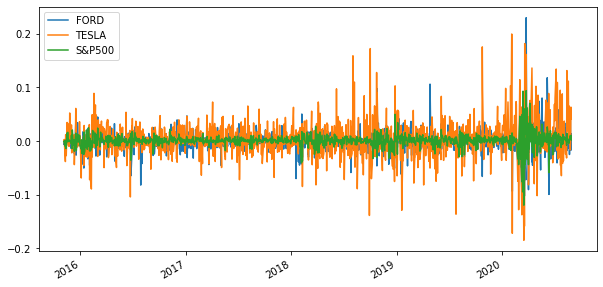

In [11]:
df_daily_returns.plot(figsize=(10,5))

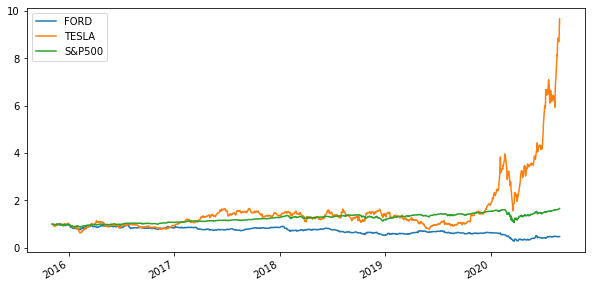

In [12]:
df_cumulative = (1 + df_daily_returns).cumprod()
df_cumulative.plot(figsize=(10,5))

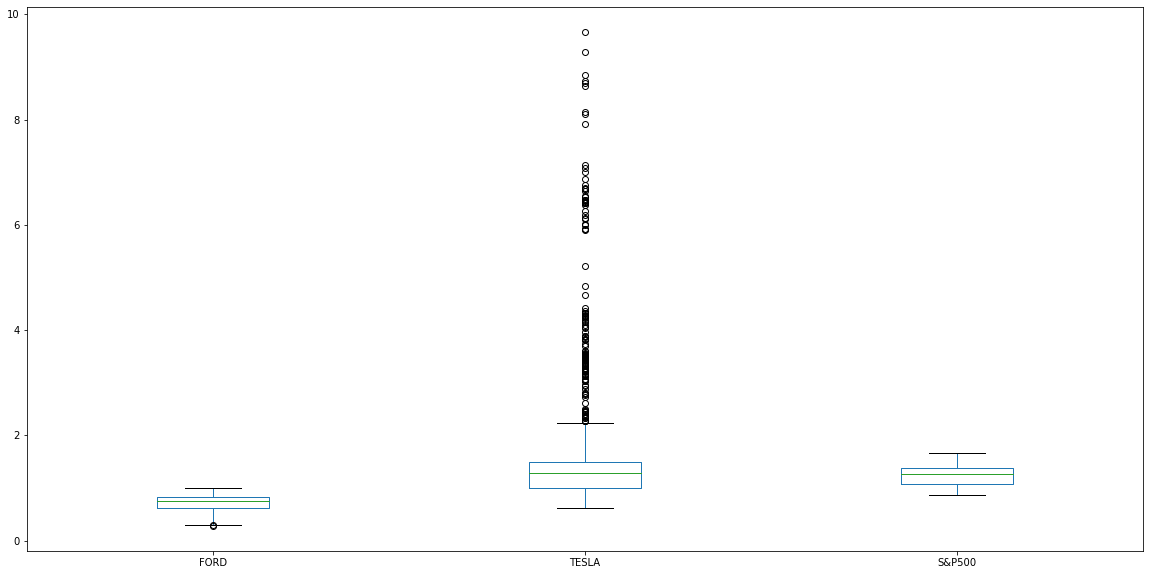

In [13]:
df_cumulative.plot.box(figsize=(20,10))

In [14]:
df_daily_returns.describe()

,FORD,TESLA,S&P500
count,1211.000000,1211.000000,1211.000000
mean,-0.000401,0.002480,0.000491
std,0.021013,0.034885,0.012086
min,-0.111901,-0.185317,-0.119841
25%,-0.009287,-0.013965,-0.002908
50%,0.000000,0.001118,0.000676
75%,0.008578,0.017588,0.005035
max,0.229927,0.199545,0.093828


In [15]:
###Calculate and plot beta of TESLA and the S&P500.
###Calculate covariance of TESLA
covariance_tesla = df_daily_returns['TESLA'].cov(df_daily_returns['S&P500'])
print(f'TESLA covariance returns vs S&P500 is: {covariance_tesla}')

TESLA covariance returns vs S&P500 is: 0.00017936639002613552


In [16]:
###Calculate variance of S&P500
variance_tesla = df_daily_returns['S&P500'].var()
print(f"Variance of S&P500 is : {variance_tesla}")

Variance of S&P500 is : 0.00014606847303478038


In [17]:
###Calculating beta of Algo 1
###Plot beta trend
beta_tesla = covariance_tesla / variance_tesla
print(f'Beta of TESLA is: {beta_tesla}')

Beta of TESLA is: 1.2279610123905833


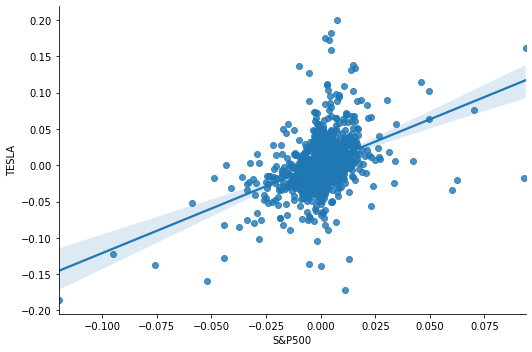

In [18]:
sns.lmplot(x="S&P500", y="TESLA", data=df_daily_returns, aspect=1.5, fit_reg=True)

In [19]:
# Create an empty DataFrame for closing prices
fiveyears_closing_prices = pd.DataFrame()

# Fetch the closing prices of FB and TWTR
fiveyears_closing_prices["Nov/2015"] = df_closing_prices.iloc[0]
fiveyears_closing_prices["Aug/2020"] = df_closing_prices.iloc[-1]
fiveyears_closing_prices["% diff"] = (fiveyears_closing_prices["Aug/2020"] / fiveyears_closing_prices["Nov/2015"]) * 100

fiveyears_closing_prices

,Nov/2015,Aug/2020,% diff
FORD,15.35,6.91,45.016287
TESLA,219.19,2239.76,1021.834938


In [20]:
 # Use the results to calculate the outcome of our initial $10,000 of investment in Apple and Tesla stocks
initial_investiment = 10000
ford_fv = initial_investiment * (fiveyears_closing_prices.iloc[0,2] / 100)
tsla_fv = initial_investiment * (fiveyears_closing_prices.iloc[1,2] / 100)

# Print results
print(f"If you have invested ${initial_investiment} over 5 years in FORD stock your balance would be ${ford_fv}"
      f" but if you have invested in tesla instead your balance would be ${tsla_fv}")

If you have invested $10000 over 5 years in FORD stock your balance would be $4501.628664495114 but if you have invested in tesla instead your balance would be $102183.49377252613


In [21]:
df_daily_returns.describe()

,FORD,TESLA,S&P500
count,1211.000000,1211.000000,1211.000000
mean,-0.000401,0.002480,0.000491
std,0.021013,0.034885,0.012086
min,-0.111901,-0.185317,-0.119841
25%,-0.009287,-0.013965,-0.002908
50%,0.000000,0.001118,0.000676
75%,0.008578,0.017588,0.005035
max,0.229927,0.199545,0.093828


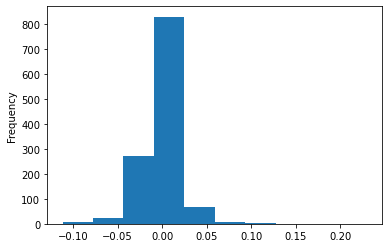

In [22]:
df_daily_returns["FORD"].plot.hist()

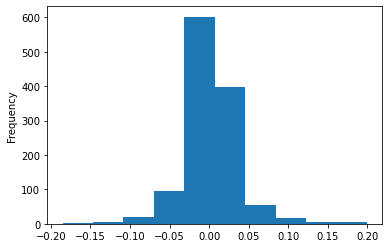

In [23]:
df_daily_returns["TESLA"].plot.hist()

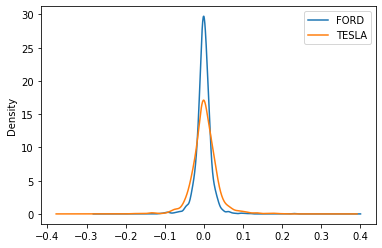

In [24]:
#Plot.density of TESLA and FORD
txl_closing_prices = df_closing_prices.pct_change().dropna()
txl_closing_prices.plot.density()